## Train a Model

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt

import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn # Nighty night warnings

%matplotlib inline


### Only needed since I'm running locally ###
import os
input_dir = os.path.join(os.getcwd(), 'input')
train_data = pd.read_csv(input_dir + r'\\train.csv')
test_data = pd.read_csv(input_dir + r'\\test.csv')

Next we need to extract the target variable, which in this case is `SalePrice`. 

In [2]:
target = train_data.SalePrice

candidate_train_predictors = train_data.drop(['Id', 'SalePrice'], axis=1)
candidate_test_predictors = test_data.drop(['Id'], axis=1)

I think one of the harder parts to grasp is one-hot encoding so let's break it down into steps.
### 1. Grab columns with low cardinality
These are the columns that have unique values and contain only a handful of possible values.

In [3]:
low_cardinality_cols = []
# Grab all columns that have less than 10 unique values
for cname in candidate_train_predictors.columns:
    col = candidate_train_predictors[cname]
    # If the number of unique values in a column < 10 and column is dtype 'object'
    if col.nunique() < 10 and col.dtype == 'object':
        low_cardinality_cols.append(cname)
print(low_cardinality_cols)
print('Low Cardinality Columns:', len(low_cardinality_cols))

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Low Cardinality Columns: 40


### 2. Grab columns that represent a number

In [4]:
# Grab all columns that are numeric 
numeric_cols = [cname for cname in candidate_train_predictors.columns if
                       candidate_train_predictors[cname].dtype in ['int64', 'float64']]
print(numeric_cols)
print('Numeric Columns:', len(numeric_cols))

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
Numeric Columns: 36


### 3. Get one-hot encoding

In [5]:
# Grab all columns that we care about
my_cols = low_cardinality_cols + numeric_cols
train_predictors = candidate_train_predictors[my_cols]
test_predictors = candidate_test_predictors[my_cols]

# Compute one-hot encoding
one_hot_encoded_training_predictors = pd.get_dummies(train_predictors)
one_hot_encoded_test_predictors = pd.get_dummies(test_predictors)

final_train, final_test = one_hot_encoded_training_predictors.align(one_hot_encoded_test_predictors,
                                                                    join='left',
                                                                    axis=1)

Well that was fast. Only 3 steps and we have some one-hot encoded data. But what exactly happened?
Let's examine the columns in `train_predictors` or more specifically the values in `my_cols` and compare them to what is in `one_hot_encoded_training_predictors`.

In [6]:
print('Length my_cols:', len(my_cols))
print('One-Hot encoded training predictors:', len(one_hot_encoded_training_predictors.columns))

Length my_cols: 76
One-Hot encoded training predictors: 232


There are many more columns in `one_hot_encoded_training_predictors` than there are values in `my_cols`. Let's take a look at a single value from `low_cardinality_cols`, `MSZoning`.

In [7]:
print(train_predictors['MSZoning'].value_counts())

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64


With one-hot encoding we end up getting a column for each unique value. In this case we should end up with five different columns, each representing a potential value that `MSZoning` can take on.

In [8]:
print([col for col in one_hot_encoded_training_predictors.columns if col.find('MSZoning') != -1])

['MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM']


Next we create an Imputer to fill in missing data rather than getting rid of it.

In [9]:
# Create Imputer for Imputing values
my_imputer = SimpleImputer()
imputed_train = my_imputer.fit_transform(final_train)
imputed_test = my_imputer.transform(final_test)

# Split into train/test set for training the XGBoost Model
train_X, test_X, train_y, test_y = train_test_split(one_hot_encoded_training_predictors, target, random_state=1)

In [10]:
def grid_search(param_grid, fit_params):
    import datetime
    start = datetime.datetime.now()
    
    my_pipeline = Pipeline([('imputer', SimpleImputer()),
                            ('xgbreg', XGBRegressor())])
    
    search_cv = GridSearchCV(my_pipeline, cv=5, param_grid=param_grid)
    search_cv.fit(train_X, train_y, **fit_params)
    
    end = datetime.datetime.now()
    print(search_cv.best_params_)
    
    diff = end - start
    minutes, seconds = divmod(diff.total_seconds(), 60)
    print('Time taken: {:.0f} minutes, {:.3f} seconds'.format(minutes, seconds))
    

Using the function above we can do a cross-validation search of the parameter and fit grids. In order to find the best values we would need to plug in each possible parameter and a range of values that it could take on in order to find the settings that work best when fitting the data. This isn't realistic as running cross-validation on such a large grid would take a very long time to run. An example of this can be seen below.

In [11]:
param_grid = {
    'xgbreg__random_state': [1],
    'xgbreg__n_estimators': [10, 50, 100, 250, 500, 1000],
    #'xgbreg__learning_rate': [0.05, .1, .15],
    #'xgbreg__max_depth' : [3, 4, 5],
}

fit_params = {
    'xgbreg__early_stopping_rounds': 5,
    'xgbreg__eval_set': [(np.array(test_X), test_y)],
    'xgbreg__verbose': False
}

grid_search(param_grid, fit_params)

# Add a parameter to maximize
param_grid['xgbreg__learning_rate'] = [.05, .1, .15]
print()
grid_search(param_grid, fit_params)

# Add another parameter
param_grid['xgbreg__max_depth'] = [3, 4, 5]
print()
grid_search(param_grid, fit_params)

{'xgbreg__n_estimators': 250, 'xgbreg__random_state': 1}
Time taken: 0 minutes, 32.312 seconds

{'xgbreg__learning_rate': 0.05, 'xgbreg__n_estimators': 250, 'xgbreg__random_state': 1}
Time taken: 1 minutes, 48.208 seconds

{'xgbreg__learning_rate': 0.1, 'xgbreg__max_depth': 4, 'xgbreg__n_estimators': 100, 'xgbreg__random_state': 1}
Time taken: 6 minutes, 12.432 seconds


As you can see it takes significantly longer to run each time because it needs to check all possible combinations of values for the given parameters in order to find what works best. Below is what I used for my model.

In [12]:
xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.05, random_state=1, max_depth=4, reg_lambda=1.5,
                         subsample=0.9, colsample_bytree=0.5)
xgb_model.fit(imputed_train, target, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, importance_type='gain',
       learning_rate=0.05, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=1, reg_alpha=0,
       reg_lambda=1.5, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9)

Now all that is left is to visualize what was learned. We can do this by using partial dependence plots. `XGBoost` has the ability to do this but seems to only give features names such as **f0**, **f1**, **f2**, etc. I wrote some code to extract these names and reference them against the feature at that given index.

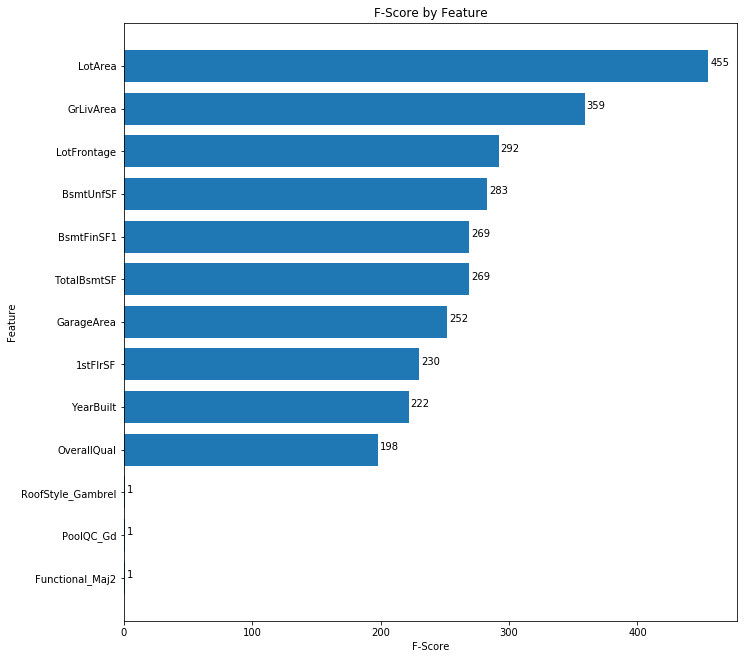

In [13]:
##### Partial Dependence Plot
vals_to_display = 10
feature_names = final_train.columns.values 
fscores = xgb_model.get_booster().get_fscore()
sorted_fscores = sorted(fscores, key=fscores.get, reverse=True)

fig, ax = plt.subplots(1, 1, figsize=(11,11))

# Reverse so largest values are at the top of bar graph
x = (sorted_fscores[:vals_to_display] + sorted_fscores[-3:])[::-1]
y = [fscores[val] for val in x]
y_pos = np.arange(len(y))

width = 0.75
ax.barh(y_pos, y, width, align='center')
ax.set_yticks(y_pos)

# F-scores are 'f10', 'f11', etc. with the same array indices as the column
# names. This just removes the 'f' and converts it to an int to do 1:1 indexing
# into the feature_names array
ax.set_yticklabels([feature_names[int(t[1:])] for t in x], minor=False)

# Add text to show number in each bar
for i, v in enumerate(y):
    ax.text(v + 1.5, i, str(v))
plt.ylabel('Feature')
plt.xlabel('F-Score')
plt.title('F-Score by Feature')
plt.show()


## Make Predictions
Read the file of "test" data. And apply your model to make predictions

In [14]:
from sklearn.metrics import mean_absolute_error

# path to file you will use for predictions
test_data_path = input_dir + r'\test.csv'

# read test data file using pandas
test_data = pd.read_csv(test_data_path)


# make predictions which we will submit. 
test_preds = xgb_model.predict(imputed_test)

output = pd.DataFrame({'Id': test_data.Id,
                      'SalePrice': test_preds})
output.to_csv('submission.csv', index=False)

And we now have a trained model that made predictions on the test data! In this case we cannot test the accuracy on the test data here as they did not provide a target column for us but we can be pretty positive that it did well based off the test data from `train_test_split` before when cross-validating. So then did we create the best model? Well let's take a look at the columns we used. Originally in the competition it has you start by using just a few features but now we have put the features we will use in `my_cols`, so let's look there.

In [15]:
print('Number of possible columns:', len(candidate_train_predictors.columns))
print('Number of columns used:', len(my_cols))

possible_cols = set(candidate_train_predictors.columns)
used_cols = set(my_cols)
unused_cols = possible_cols ^ used_cols
print('Unussed columns:', unused_cols)
print([candidate_train_predictors[col].dtype for col in unused_cols])
print('\n'.join(['{}: {}'.format(col, candidate_train_predictors[col].nunique())
                 for col in unused_cols]))

Number of possible columns: 79
Number of columns used: 76
Unussed columns: {'Exterior1st', 'Neighborhood', 'Exterior2nd'}
[dtype('O'), dtype('O'), dtype('O')]
Exterior1st: 15
Neighborhood: 25
Exterior2nd: 16


So we aren't actually using all of the columns. Since our columns we considered for low cardinality were ones with less than 10 unique values, we end up leaving this ones out. Their `dtype` is "O", or Object, which in this case just assume it means string. This means these columns won't be picked up by our numeric columns either.

One of the best ways to gain knowledge is by doing. Try tweaking some of the parameters and seeing how the partial dependence plot changes. Do these changes make sense to you? Sometimes you don't need to look at MAE to determine if your model made the correct prediction. I included the worst three f-score features as well. If you tweak the model in such a way that `RoofStyle_Gambrel` somehow makes it into a top f-score, then there is something most likely wrong with the model. If there is a feature you don't think people would care about in the top 10 f-scores, it might be time to consider tweaking the parameters and retraining your model!